In [2]:
import gzip
import math
import os
import re
import sys
from enum import Enum
from io import StringIO
from time import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as pyplot
import requests
import tensorflow
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# Load the data
file_path = 'Train_data.csv'
df = pd.read_csv(file_path)

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],
# [0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode features
for name in df.columns:
    if name == 'outcome':
        pass
    elif name in ['protocol_type','service','flag','land','logged_in',
                  'is_host_login','is_guest_login']:
        encode_text_dummy(df, name)
    else:
        encode_numeric_zscore(df, name)    


C:\Users\anuja\AppData\Local\Temp\ipykernel_11780\3543708122.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
C:\Users\anuja\AppData\Local\Temp\ipykernel_11780\3543708122.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
C:\Users\anuja\AppData\Local\Temp\ipykernel_11780\3543708122.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

In [3]:

# Remove any columns with NaN values
df.dropna(inplace=True, axis=1)

# Display first 5 rows
# print(df.head())

# Prepare data for classification
x_columns = df.columns.drop('outcome')
x = df[x_columns].values
dummies = pd.get_dummies(df['outcome'])  # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

# Convert to float32
x = x.astype('float32')
y = y.astype('float32')


In [4]:
df.groupby('outcome')['outcome'].count()


outcome
back                  968
buffer_overflow        30
ftp_write               8
guess_passwd           53
imap                   12
ipsweep              3723
land                   19
loadmodule              9
multihop                7
neptune            242149
nmap                 1554
normal             812813
perl                    3
phf                     4
pod                   206
portsweep            3564
rootkit                10
satan                5019
smurf                3007
spy                     2
teardrop              918
warezclient           893
warezmaster            20
Name: outcome, dtype: int64

In [8]:

# Split the data
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential([
    Dense(10, input_dim=x.shape[1], activation='relu'),
    Dense(50, activation='relu'),
    Dense(10, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up early stopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=5, verbose=1, mode='auto',
                        restore_best_weights=True)
model.summary() 


c:\Users\anuja\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │         1,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │           550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 23)             │           253 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,573 (10.05 KB)

 Trainable params: 2,573 (10.05 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train the model
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    callbacks=[monitor],
                    verbose=2,
                    epochs=50,
                    batch_size=32)


Epoch 1/50
25196/25196 - 23s - 917us/step - accuracy: 0.9990 - loss: 0.0045 - val_accuracy: 0.9988 - val_loss: 0.0048
Epoch 2/50
25196/25196 - 31s - 1ms/step - accuracy: 0.9990 - loss: 0.0041 - val_accuracy: 0.9991 - val_loss: 0.0055
Epoch 3/50
25196/25196 - 30s - 1ms/step - accuracy: 0.9991 - loss: 0.0046 - val_accuracy: 0.9990 - val_loss: 0.0048
Epoch 4/50
25196/25196 - 26s - 1ms/step - accuracy: 0.9991 - loss: 0.0040 - val_accuracy: 0.9991 - val_loss: 0.0060
Epoch 5/50
25196/25196 - 24s - 965us/step - accuracy: 0.9991 - loss: 0.0039 - val_accuracy: 0.9991 - val_loss: 0.0043
Epoch 6/50
25196/25196 - 22s - 881us/step - accuracy: 0.9992 - loss: 0.0046 - val_accuracy: 0.9991 - val_loss: 0.0044
Epoch 7/50
25196/25196 - 22s - 888us/step - accuracy: 0.9991 - loss: 0.0046 - val_accuracy: 0.9990 - val_loss: 0.0049
Epoch 8/50
25196/25196 - 22s - 878us/step - accuracy: 0.9991 - loss: 0.0043 - val_accuracy: 0.9991 - val_loss: 0.0044
Epoch 9/50
25196/25196 - 22s - 890us/step - accuracy: 0.9992 -

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {loss:.3f}')
print(f'Test accuracy: {accuracy:.3f}')
model.save('classifier_model_2.h5')

In [9]:
modell = tensorflow.keras.models.load_model('classifier_model_2.h5')
y_pred = modell.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


8399/8399 ━━━━━━━━━━━━━━━━━━━━ 8s 930us/step


In [10]:

# Print classification report
print(classification_report(y_true_classes, y_pred_classes))


c:\Users\anuja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anuja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       254
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         1
           3       1.00      0.78      0.88         9
           4       0.50      0.33      0.40         3
           5       0.99      0.96      0.98       952
           6       0.50      0.20      0.29         5
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00     60413
          10       0.96      0.96      0.96       361
          11       1.00      1.00      1.00    203322
          13       0.00      0.00      0.00         2
          14       1.00      1.00      1.00        48
          15       1.00      0.99      1.00       898
          16       0.00      0.00      0.00         1
          17       0.99      0.98      0.99      1266
          18       0.99      1.00      0.99       723
          19       0.00    

c:\Users\anuja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


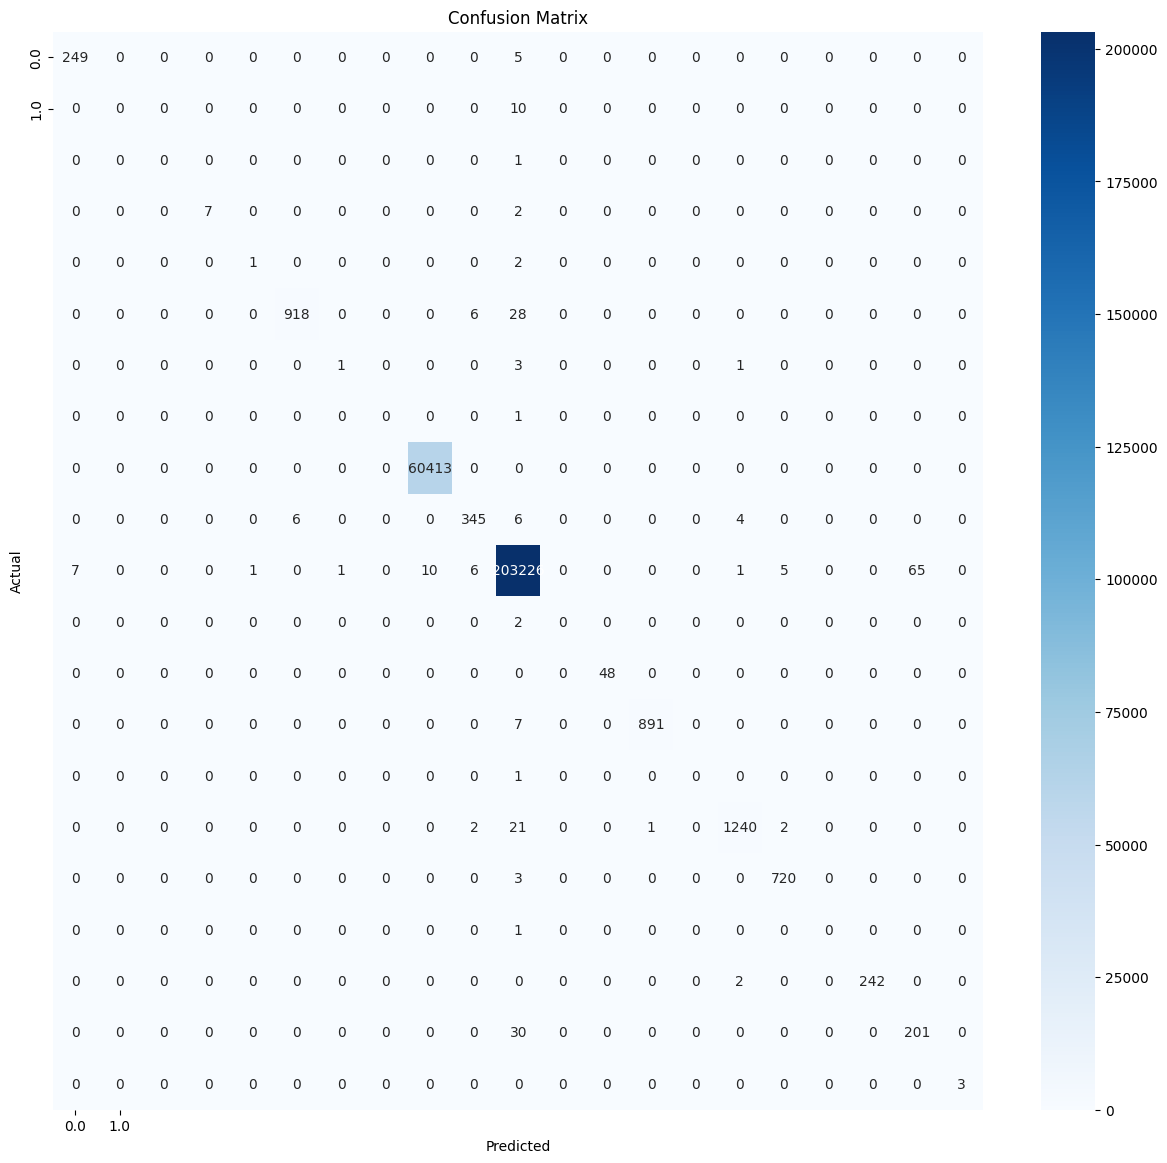

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
# Print confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
# print("Confusion Matrix:")
# print(cm)
plt.figure(figsize=(15, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [20]:
my_dict={
    0: 'back',
    1: 'buffer_overflow',
    2: 'ftp_write',
    3: 'guess_passwd',
    4: 'imap',
    5: 'ipsweep',
    6: 'land',
    7: 'loadmodule',
    8: 'multihop',
    9: 'neptune',
    10: 'nmap',
    11: 'normal',
    12: 'perl',
    13: 'phf',
    14: 'pod',
    15: 'portsweep',
    16: 'rootkit',
    17: 'satan',
    18: 'smurf',
    19: 'spy',
    20: 'teardrop',
    21: 'warezclient',
    22: 'warezmaster'
}

In [17]:
from sklearn import metrics
pred = modell.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))

8399/8399 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Validation score: 0.9990958072246119


In [22]:
keyword_list = [my_dict[num] for num in pred]
test_result = pd.DataFrame({'actual': [my_dict[num] for num in y_eval], 'predicted': keyword_list})